In [1]:
# Imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

torch.cuda.empty_cache()

In [2]:
model = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to('cuda')
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth"))

<All keys matched successfully>

In [3]:
def get_model_weights(model):
    weights = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):  
            weights.append(module.weight.detach().cpu().numpy())  
    return weights

In [4]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        # Flatten the parameter tensors and count zeros
        flattened_params = param.view(-1)
        # TODO: instead of zero, get less than a threshold really small 10⁻8
        zero_params += torch.sum(flattened_params <= 1e-4).item()
        total_params += flattened_params.size(0)

    sparsity = zero_params / total_params
    return sparsity

In [5]:
threshold = 1e-3  
sparsity_threshold = 1e-4 


def analyze_weights(weights, threshold, model):
    # Flatten each weight matrix and perform the comparison
    above_threshold = sum(np.count_nonzero(np.abs(weight.flatten()) > threshold) for weight in weights)
    below_threshold = sum(np.count_nonzero(np.abs(weight.flatten()) <= threshold) for weight in weights)
    sparsity = sum(np.count_nonzero(np.abs(weight.flatten()) <= 1e-8) for weight in weights)  # Adjust the threshold for sparsity as needed
    
    return above_threshold, below_threshold, sparsity



weights_model = get_model_weights(model)
weights_model_l1 = get_model_weights(model_regularized_l1)
weights_model_l2 = get_model_weights(model_regularized_l2)

analysis_model = analyze_weights(weights_model, threshold, model)
analysis_model_l1 = analyze_weights(weights_model_l1, threshold, model_regularized_l1)
analysis_model_l2 = analyze_weights(weights_model_l2, threshold, model_regularized_l2)

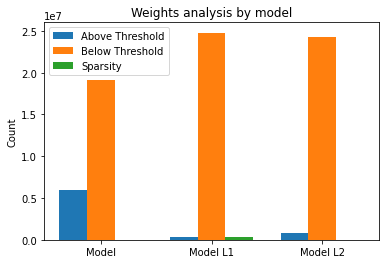

In [6]:
labels = ['Model', 'Model L1', 'Model L2']
above_threshold_values = [analysis_model[0], analysis_model_l1[0], analysis_model_l2[0]]
below_threshold_values = [analysis_model[1], analysis_model_l1[1], analysis_model_l2[1]]
sparsity_values = [analysis_model[2], analysis_model_l1[2], analysis_model_l2[2]]


x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, above_threshold_values, width, label='Above Threshold')
rects2 = ax.bar(x, below_threshold_values, width, label='Below Threshold')
rects3 = ax.bar(x + width, sparsity_values, width, label='Sparsity')


# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_title('Weights analysis by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

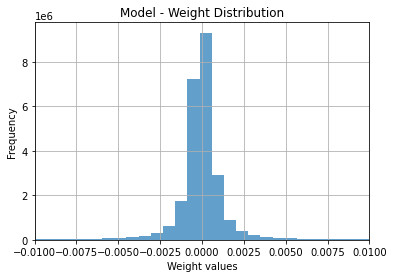

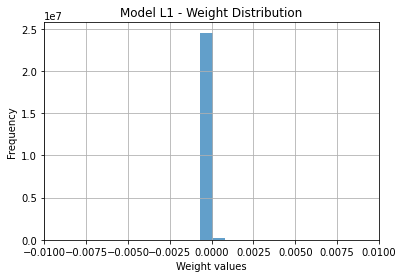

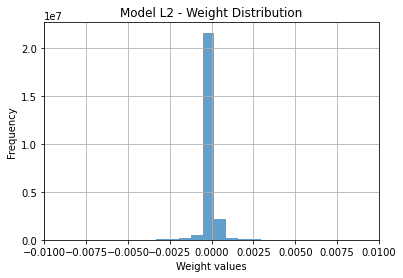

In [7]:
import matplotlib.pyplot as plt

def plot_weight_histogram(weights, title):
    # Flatten all weight arrays and combine them into one list
    all_weights = np.hstack([w.flatten() for w in weights])

    plt.hist(all_weights, bins=1000, alpha=0.7)
    plt.xlim((-0.01, 0.01))
    plt.title(title)
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_weight_histogram(weights_model, "Model - Weight Distribution")
plot_weight_histogram(weights_model_l1, "Model L1 - Weight Distribution")
plot_weight_histogram(weights_model_l2, "Model L2 - Weight Distribution")